#**Facial Emotion Recognition**

In [1]:
#Import Required Libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils


##**Load & Plot Data**

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()


(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()


array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear',
                         3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


In [5]:
df.emotion.value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


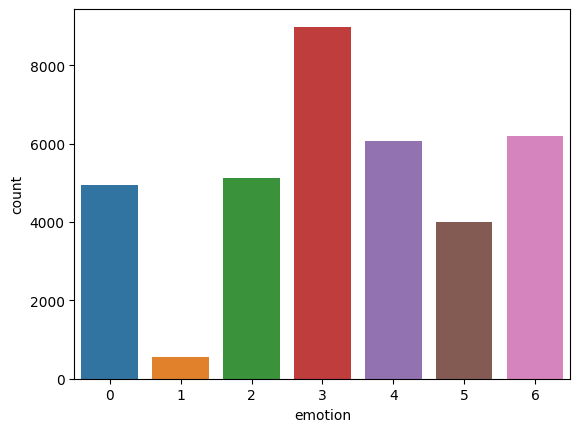

In [6]:
sns.countplot(df.emotion)
pyplot.show()


In [7]:
math.sqrt(len(df.pixels[0].split(' ')))


48.0

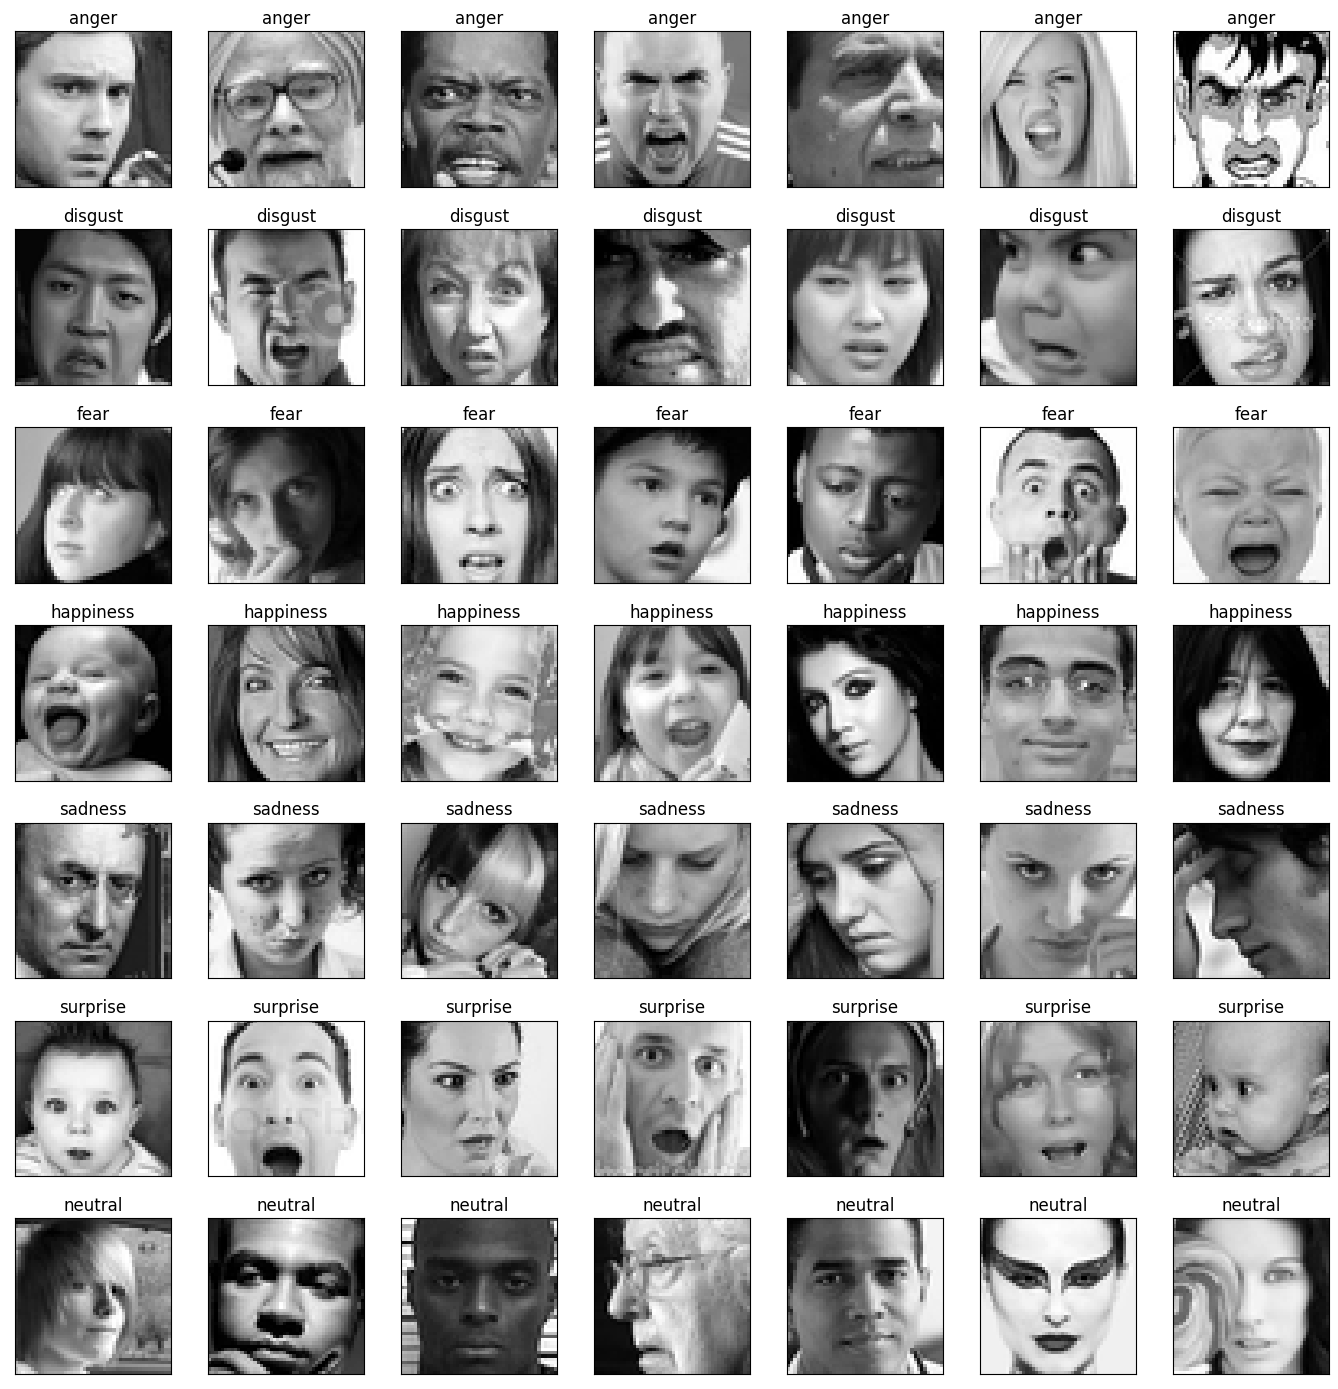

In [8]:
import itertools
fig = pyplot.figure(1, (14, 14))

k = 0
for label, _ in itertools.product(sorted(df.emotion.unique()), range(7)):
    px = df[df.emotion == label].pixels.iloc[k]
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

    k += 1
    ax = pyplot.subplot(7, 7, k)
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[label])
    pyplot.tight_layout()


In [9]:
INTERESTED_LABELS = [3, 4, 6]


In [10]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape


(21264, 3)

In [11]:
img_array = df.pixels.apply(lambda x: np.array(
    x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)


In [12]:
img_array.shape


(21264, 48, 48, 1)

##**Prepare Dataset**

In [13]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape


(21264, 3)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)


{3: 0, 4: 1, 6: 2}


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                      shuffle=True, stratify=img_labels,
                                                      test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [16]:
del df
del img_array
del img_labels


In [17]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]


In [18]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.


##**Build & Train Model**|

In [19]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3, 3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net


In [20]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)


In [21]:
batch_size = 32  # batch size of 32 performs the best.
epochs = 5
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                     beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [22]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/5
598/598 [==============================] - 773s 1s/step - loss: 1.3186 - accuracy: 0.4011 - val_loss: 1.0063 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 2/5
598/598 [==============================] - 705s 1s/step - loss: 1.0360 - accuracy: 0.4742 - val_loss: 0.9451 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 3/5
598/598 [==============================] - 829s 1s/step - loss: 0.9589 - accuracy: 0.5265 - val_loss: 0.7848 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 4/5
598/598 [==============================] - 844s 1s/step - loss: 0.8393 - accuracy: 0.5964 - val_loss: 0.7977 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 5/5
598/598 [==============================] - 892s 1s/step - loss: 0.7701 - accuracy: 0.6383 - val_loss: 0.6606 - val_accuracy: 0.7113 - lr: 0.0010


##**Save and Load Model**

In [23]:
# save trained model and also its history
from keras.models import save_model
save_model(model, "best_model.h5")
np.save('my_history.npy',history.history)

In [24]:
from numpy import loadtxt
from keras.models import load_model
import numpy as np
model = load_model('best_model.h5')
history=np.load('my_history.npy',allow_pickle='TRUE').item()
# summarize model.
model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

#**Validation**

In [26]:
# Model evaluation
scores = model.evaluate(X_valid, y_valid, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 71.13%


<AxesSubplot:>

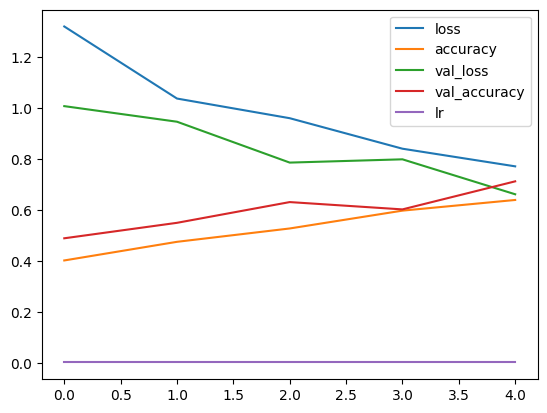

In [27]:
import pandas as pd
pd.DataFrame(history).plot()

##**Testing**

In [35]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
def predictImage(filename):
    img1 = filename
    plt.imshow(img1)
    Y = image.img_to_array(img1)
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X.reshape((1,48,48,1)))
    val=list(val[0])
    mx=max(val)
    print(f'{mx*100:.2f}% Accurate')
    val = val.index(mx)
    print(f'Label Index is {val}')
    if val == 0:
        plt.xlabel("Anger",fontsize=30)
    elif val == 1:
        plt.xlabel("Disguest",fontsize=30)
    elif val == 2:
        plt.xlabel("Fear",fontsize=30)
    elif val == 3:
        plt.xlabel("Happiness",fontsize=30)
    elif val == 4:
        plt.xlabel("Saddness",fontsize=30)
    elif val == 5:
        plt.xlabel("Surprise",fontsize=30)
    elif val == 6:
        plt.xlabel("Neutral",fontsize=30)


1/1 [==============================] - 0s 46ms/step
77.69% Accurate
Label Index is 2


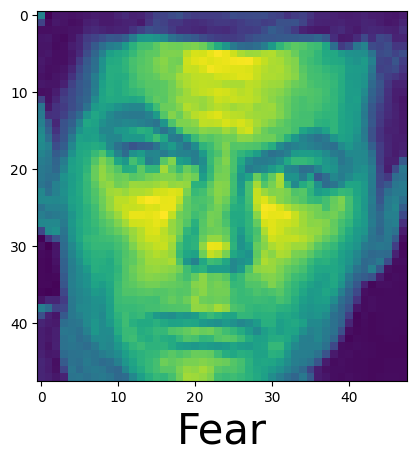

In [48]:
predictImage(X_train[5])